### Do models with a better EP also have a better CP?

In [27]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Temp NINO

In [28]:
EP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_EP_temp_regressions')
CP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_CP_temp_regressions')

In [29]:
# Read in the quadratically detrended 20CR temp
temp = xr.open_dataarray('/g/data/w40/rl5183/20CR_tmp_ensemble_mean_quad_detrend_1.5x1.5.nc')
# Calculate anomalies
clim = temp.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = (temp.groupby('time.month') - clim)
# Take DJF average
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))
# NINO indices from Hadisst
sst = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc').sst
# Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate EP and CP index
nino3 = func.nino3_index(sst_dt, '1979-01', '2008-12')
nino4 = func.nino4_index(sst_dt, '1979-01', '2008-12')
# Calculate EP and CP index
EP_sst = (nino3 - 0.5*nino4).sel(time=slice('1900-01', '2014-12'))
CP_sst = (nino4 - 0.5*nino3).sel(time=slice('1900-01', '2014-12'))
# Take DJF average of EP index and CP index
quarterly_EP = EP_sst.resample(time='QS-DEC').mean('time')
djf_EP = quarterly_EP.isel(time=slice(0,None,4))

quarterly_CP = CP_sst.resample(time='QS-DEC').mean('time')
djf_CP = quarterly_CP.isel(time=slice(0,None,4))
# Regression
EP_regress_20CR = func.regress_nino(djf_anom, djf_EP)
CP_regress_20CR = func.regress_nino(djf_anom, djf_CP)

In [30]:
pattern_cor_EP = []
for m in EP_regressions.model:
    pattern_cor_EP.append(func.pattern_cor(EP_regressions.sel(model=m), EP_regress_20CR))
pattern_cor_CP = []
for m in CP_regressions.model:
    pattern_cor_CP.append(func.pattern_cor(CP_regressions.sel(model=m), CP_regress_20CR))
pattern_cor_EP = np.array(pattern_cor_EP)
pattern_cor_CP = np.array(pattern_cor_CP)

In [31]:
m, b = np. polyfit(pattern_cor_EP, pattern_cor_CP, 1)

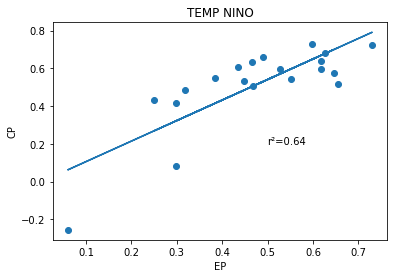

In [32]:
plt.scatter(pattern_cor_EP, pattern_cor_CP)
plt.plot(pattern_cor_EP, m*pattern_cor_EP + b)
plt.text(0.5, 0.2, f'r\N{SUPERSCRIPT TWO}=0.64')
plt.title('TEMP NINO')
plt.xlabel('EP')
plt.ylabel('CP')
plt.savefig('EP_v_CP_TEMP_NINO', bbox_inches='tight', dpi=300)

In [33]:
corr_matrix = np.corrcoef(pattern_cor_EP, pattern_cor_CP)
corr = corr_matrix[0,1]
r_sq = corr**2
print(r_sq)

0.635273931705135


### Temp EOF

In [34]:
E_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_E_temp_regressions')
C_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_C_temp_regressions')

In [35]:
E_regressions_new = []
for m in E_regressions.model:
    if E_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        E_regressions_new.append(E_regressions.sel(model=m)*-1)
    else: E_regressions_new.append(E_regressions.sel(model=m))
E_regressions_new = xr.concat(E_regressions_new, dim='model')

In [36]:
C_regressions_new = []
for m in C_regressions.model:
    if C_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        C_regressions_new.append(C_regressions.sel(model=m)*-1)
    else: C_regressions_new.append(C_regressions.sel(model=m))
C_regressions_new = xr.concat(C_regressions_new, dim='model')

In [37]:
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-15,15)).sel(lon=slice(140,280)).sel(time=slice('1900-01', '2014-12'))
# Quadtratically Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate anomalies 
clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst_dt.groupby('time.month') - clim
# EOFs
had_eof, had_pcs, had_var = func.eof_and_pcs(anom, 3)
# Scale PCs to have a standrd deviation of 1 
had_pc1 = (had_pcs.sel(mode=1)/had_pcs.sel(mode=1).std())*-1
had_pc2 = had_pcs.sel(mode=2)/had_pcs.sel(mode=2).std()
# Calculate E-index and C-index
had_E = (had_pc1 - had_pc2)/np.sqrt(2)
had_C = (had_pc1 + had_pc2)/np.sqrt(2)
# Take DJF average of E-index and C-index
had_quarterly_E = had_E.resample(time='QS-DEC').mean('time')
had_djf_E = had_quarterly_E.isel(time=slice(0,None,4))

had_quarterly_C = had_C.resample(time='QS-DEC').mean('time')
had_djf_C = had_quarterly_C.isel(time=slice(0,None,4))

# Regression
EP_regress_20CR = func.regress_nino(djf_anom, had_djf_E)
CP_regress_20CR = func.regress_nino(djf_anom, had_djf_C)

In [38]:
pattern_cor_EP = []
for m in E_regressions_new.model:
    pattern_cor_EP.append(func.pattern_cor(E_regressions_new.sel(model=m), EP_regress_20CR))
pattern_cor_CP = []
for m in C_regressions_new.model:
    pattern_cor_CP.append(func.pattern_cor(C_regressions_new.sel(model=m), CP_regress_20CR))
pattern_cor_EP = np.array(pattern_cor_EP)
pattern_cor_CP = np.array(pattern_cor_CP)

In [39]:
m, b = np. polyfit(pattern_cor_EP, pattern_cor_CP, 1)

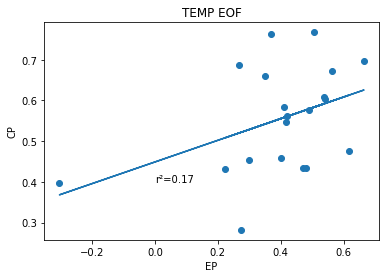

In [40]:
plt.scatter(pattern_cor_EP, pattern_cor_CP)
plt.plot(pattern_cor_EP, m*pattern_cor_EP + b)
plt.text(0, 0.4, f'r\N{SUPERSCRIPT TWO}=0.17')
plt.title('TEMP EOF')
plt.xlabel('EP')
plt.ylabel('CP')
plt.savefig('EP_v_CP_TEMP_EOF', bbox_inches='tight', dpi=300)

In [41]:
corr_matrix = np.corrcoef(pattern_cor_EP, pattern_cor_CP)
corr = corr_matrix[0,1]
r_sq = corr**2
print(r_sq)

0.17057676778676123


In [42]:
pattern_cor_EP

array([ 0.40206031,  0.42054198,  0.2238939 ,  0.40902084,  0.47957992,
        0.53718915,  0.29973055,  0.61694985,  0.47052687,  0.27287048,
       -0.30419349,  0.26606046,  0.54091039,  0.48965975,  0.66451312,
        0.50599271,  0.3508076 ,  0.41572314,  0.5638175 ,  0.36886971])

In [43]:
pattern_cor_CP

array([0.45973733, 0.56265474, 0.43264347, 0.58419603, 0.43492403,
       0.6092871 , 0.45366993, 0.47693441, 0.43464716, 0.28194501,
       0.39635631, 0.68706159, 0.60291909, 0.57728812, 0.69734957,
       0.76733133, 0.65976737, 0.54796228, 0.67139522, 0.76241538])

### Precip NINO

In [44]:
EP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_EP_pr_regressions')
CP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_CP_pr_regressions')

In [45]:
# Read in the 20CR precip
precip = xr.open_dataarray('/g/data/w40/rl5183/20CR_pr_ensemble_mean_1.5x1.5.nc').sel(time=slice('1900-01', '2014-12'))*86400
# Calculate anomalies
clim = precip.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = (precip.groupby('time.month') - clim)
# Take DJF average
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))
# NINO indices from Hadisst
sst = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc').sst
# Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate EP and CP index
nino3 = func.nino3_index(sst_dt, '1979-01', '2008-12')
nino4 = func.nino4_index(sst_dt, '1979-01', '2008-12')
# Calculate EP and CP index
EP_sst = (nino3 - 0.5*nino4).sel(time=slice('1900-01', '2014-12'))
CP_sst = (nino4 - 0.5*nino3).sel(time=slice('1900-01', '2014-12'))
# Take DJF average of EP index and CP index
quarterly_EP = EP_sst.resample(time='QS-DEC').mean('time')
djf_EP = quarterly_EP.isel(time=slice(0,None,4))

quarterly_CP = CP_sst.resample(time='QS-DEC').mean('time')
djf_CP = quarterly_CP.isel(time=slice(0,None,4))
# Regression
EP_regress_20CR = func.regress_nino(djf_anom, djf_EP)
CP_regress_20CR = func.regress_nino(djf_anom, djf_CP)

In [46]:
pattern_cor_EP = []
for m in EP_regressions.model:
    pattern_cor_EP.append(func.pattern_cor(EP_regressions.sel(model=m), EP_regress_20CR))
pattern_cor_CP = []
for m in CP_regressions.model:
    pattern_cor_CP.append(func.pattern_cor(CP_regressions.sel(model=m), CP_regress_20CR))
pattern_cor_EP = np.array(pattern_cor_EP)
pattern_cor_CP = np.array(pattern_cor_CP)

In [47]:
m, b = np. polyfit(pattern_cor_EP, pattern_cor_CP, 1)

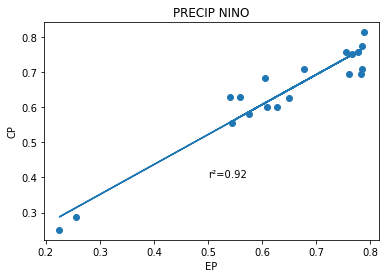

In [48]:
plt.scatter(pattern_cor_EP, pattern_cor_CP)
plt.plot(pattern_cor_EP, m*pattern_cor_EP + b)
plt.text(0.5, 0.4, f'r\N{SUPERSCRIPT TWO}=0.92')
plt.title('PRECIP NINO')
plt.xlabel('EP')
plt.ylabel('CP')
plt.savefig('EP_v_CP_PRECIP_NINO', bbox_inches='tight', dpi=300)

In [49]:
corr_matrix = np.corrcoef(pattern_cor_EP, pattern_cor_CP)
corr = corr_matrix[0,1]
r_sq = corr**2
print(r_sq)

0.919978745026953


### Precip EOF

In [50]:
E_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_E_pr_regressions')
C_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_C_pr_regressions')

In [51]:
E_regressions_new = []
for m in E_regressions.model:
    if m == 'ACCESS-CM2' or m == 'BCC-CSM2-MR' or m == 'GFDL-ESM4' or m == 'INM-CM4-8' or m == 'INM-CM5-0' or m == 'KACE-1-0-G' or m == 'MIROC6' or m == 'MPI-ESM1-2-HR' or m == 'MRI-ESM2-0' or m == 'NorESM2-LM' or m == 'NorESM2-MM':
        E_regressions_new.append(E_regressions.sel(model=m)*-1)
    else: E_regressions_new.append(E_regressions.sel(model=m))
E_regressions_new = xr.concat(E_regressions_new, dim='model')

In [52]:
C_regressions_new = []
for m in C_regressions.model:
    if m == 'ACCESS-CM2' or m == 'BCC-CSM2-MR' or m == 'GFDL-ESM4' or m == 'INM-CM4-8' or m == 'INM-CM5-0' or m == 'KACE-1-0-G' or m == 'MIROC6' or m == 'MPI-ESM1-2-HR' or m == 'MRI-ESM2-0' or m == 'NorESM2-LM' or m == 'NorESM2-MM':
        C_regressions_new.append(C_regressions.sel(model=m)*-1)
    else: C_regressions_new.append(C_regressions.sel(model=m))
C_regressions_new = xr.concat(C_regressions_new, dim='model')

In [53]:
# Read in the 20CR precip
precip = xr.open_dataarray('/g/data/w40/rl5183/20CR_pr_ensemble_mean_1.5x1.5.nc').sel(time=slice('1900-01', '2014-12'))*86400
# Calculate anomalies
clim = precip.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = (precip.groupby('time.month') - clim)
# Take DJF average
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-15,15)).sel(lon=slice(140,280)).sel(time=slice('1900-01', '2014-12'))
# Quadtratically Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate anomalies 
clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst_dt.groupby('time.month') - clim
# EOFs
had_eof, had_pcs, had_var = func.eof_and_pcs(anom, 3)
# Scale PCs to have a standrd deviation of 1 
had_pc1 = (had_pcs.sel(mode=1)/had_pcs.sel(mode=1).std())*-1
had_pc2 = had_pcs.sel(mode=2)/had_pcs.sel(mode=2).std()
# Calculate E-index and C-index
had_E = (had_pc1 - had_pc2)/np.sqrt(2)
had_C = (had_pc1 + had_pc2)/np.sqrt(2)
# Take DJF average of E-index and C-index
had_quarterly_E = had_E.resample(time='QS-DEC').mean('time')
had_djf_E = had_quarterly_E.isel(time=slice(0,None,4))

had_quarterly_C = had_C.resample(time='QS-DEC').mean('time')
had_djf_C = had_quarterly_C.isel(time=slice(0,None,4))

# Regression
EP_regress_20CR = func.regress_nino(djf_anom, had_djf_E)
CP_regress_20CR = func.regress_nino(djf_anom, had_djf_C)

In [54]:
pattern_cor_EP = []
for m in E_regressions_new.model:
    pattern_cor_EP.append(func.pattern_cor(E_regressions_new.sel(model=m), EP_regress_20CR))
pattern_cor_CP = []
for m in C_regressions_new.model:
    pattern_cor_CP.append(func.pattern_cor(C_regressions_new.sel(model=m), CP_regress_20CR))
pattern_cor_EP = np.array(pattern_cor_EP)
pattern_cor_CP = np.array(pattern_cor_CP)

In [55]:
m, b = np. polyfit(pattern_cor_EP, pattern_cor_CP, 1)

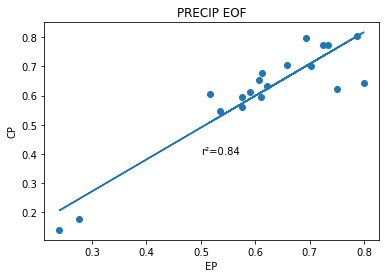

In [56]:
plt.scatter(pattern_cor_EP, pattern_cor_CP)
plt.plot(pattern_cor_EP, m*pattern_cor_EP + b)
plt.text(0.5, 0.4, f'r\N{SUPERSCRIPT TWO}=0.84')
plt.title('PRECIP EOF')
plt.xlabel('EP')
plt.ylabel('CP')
plt.savefig('EP_v_CP_PRECIP_EOF', bbox_inches='tight', dpi=300)

In [57]:
corr_matrix = np.corrcoef(pattern_cor_EP, pattern_cor_CP)
corr = corr_matrix[0,1]
r_sq = corr**2
print(r_sq)

0.8403443498272477
